Author: <a href="http://www.shugert.com.mx">Samuel Noriega</a>

# DRAW: A Recurrent Neural Network For Image Generation
A Google Deepmind's project.

The purpose of this notebook is to implement and understand Google Deepmind's paper <a href="https://arxiv.org/abs/1502.04623">DRAW: A Recurrent Neural Network For Image Generation</a>. The code is based on the work of <a href="http://blog.evjang.com/2016/06/understanding-and-implementing.html">Eric Jang</a>, who in his original code was able to achieve the implementation in only 158 lines of Python code.

## Let's beging by explaining what does DRAW stands for...

Deep Recurrent Attentive Writer (DRAW) is a neural network architecture for image generation. DRAW networks combine
a novel spatial attention mechanism that mimics the foveation of the human eye, with a sequential variational auto-encoding framework that allows for the iterative construction of complex images.

The system substantially improves on the state of the art for generative models on MNIST, and, when trained on the Street View House Numbers dataset, it generates images that cannot be distinguished from real data with the naked eye.

The core of the DRAW architecture is a pair of recurrent neural networks: an encoder network that compresses the
real images presented during training, and a decoder that reconstitutes images after receiving codes. The combined
system is trained end-to-end with stochastic gradient descent, where the loss function is a variational upper bound
on the log-likelihood of the data.

## DRAW architecture

DRAW Network is similar to other variational auto-encoders, it contains an <strong>encoder</strong> network that determines a distribution over latent codes that capture salient information about the input data and a <strong>decoder</strong> network receives samples from the code distribuion and uses them to condition its own distribution over images.


### 3 Key Differences Between DRAW and Auto-Encoders

1. Both, the enconder and decoder are recurrent networks in DRAW.
2. Decoder's output are added successively to the distribution in order to generate the data, instead of generating this the distribution in single steps.
3. A dynamically updated attention mechanism is used to restrict both the input region observed by the encoder, and the output region modified by the decoder. <b><i> In simple terms, the network decides at each time-step “where to read” and “where to write” as well as “what to write”.</i></b>

<div align="center">
    <img src="images/01.png" alt="Draw Architecture" /><br />
    <div style="width:50%;padding:0 5%;float:left">
        <p><strong>Left: Conventional Variational Auto-Encoder.</strong><br /> During generation, a sample $z$ is drawn from a prior $P(z)$ and passed through the feedforward decoder network to compute the probability of the input $P(x \mid z)$ given the sample.</p>
        <p>During inference the input $x$ is passed to the encoder network, producing an approximate posterior $Q (z \mid x)$ over latent variables. During training, $z$ is sampled from $Q (z \mid x)$ and then used to compute the total description length $KL  (Q(Z \mid x) \mid\mid P(Z) − log(P(x \mid z))$, which is
minimised with <a href="https://en.wikipedia.org/wiki/Stochastic_gradient_descent">stochastic gradient descent</a>.
        </p>
    </div>
    <div style="width:50%;padding:0 5%;float:right;">
        <p><strong>Right: DRAW Network.</strong><br />
At each time-step a sample $zt$ from the prior $P(zt)$ is passed to the recurrent decoder network, which then modifies part of the canvas matrix. The final canvas matrix $cT$ is used to compute $P(x \mid z1:T )$.</p>
        <p>During inference the input is read at every timestep and the result is passed to the encoder RNN. <a href="https://en.wikipedia.org/wiki/Recurrent_neural_network">The RNNs</a> at the previous time-step specify where to read. The output of the encoder RNN is used to compute the approximate posterior over the latent variables at that time-step.
        </p>
    </div>
</div>

### Loss Function

The final canvas matrix $cT$ is used to parameterise a model $D(X \mid cT)$ of the input data. If the input is binary, the natural choice for $D$ is a <a href="https://en.wikipedia.org/wiki/Bernoulli_distribution">Bernoulli distribution</a> with means given by $\sigma(cT)$. The reconstruction loss $L_{x}$ is defined as the negative log probability of $x$ under $D$:

$$L^{x} = − log D (x \mid cT )$$

The latent loss $L^z$ for a sequence of latent distributions $Q(Z_t \mid h^{enc}_t)$ is defined as the summed Kullback-Leibler divergence of some latent prior $P(Z_t)$ from $Q(Z_t \mid h^{enc}_t)$:

$$L^z = \sum^{T}_{t=1} KL (Q(Z_t \mid h^{enc}_t) \mid\mid P(Z_t))$$

Note that this loss depends upon the latent samples $z_t$ drawn from $Q(Z_t \mid h^{enc}_t)$, which depend in turn on the input $x$. If the latent distribution is a diagonal Gaussian with $\mu_t$, $\sigma_t$ where $\mu_t = W (h^{enc}_t)$  and $\sigma_t = exp (W (h^{enc}_t))$, a simple choice for $P(Z_t)$ is a standard Gaussian with mean zero and standard deviation one, in which case the equation becomes:

$$L^z = \frac{1}{2} ( \sum^{T}_{t=1} \mu^2_t + \sigma^2_t − log \sigma^2_t ) − T /2 $$

The total loss $L$ for the network is the expectation of the sum of the reconstruction and latent losses:

$$L = (L^x + L^z)_{z \sim Q}$$

Which we optimise using a single sample of $z$ for each stochastic gradient descent step.

$L^z$ can be interpreted as the number of nats required to transmit the latent sample sequence $z_{1:T}$ to the decoder
from the prior, and (if $x$ is discrete) $L^x$ is the number of nats required for the decoder to reconstruct $x$ given $z_{1:T}$. The total loss is therefore equivalent to the expected compression of the data by the decoder and prior.

## Improving Images

As Eric Jang mentions on <a href="http://blog.evjang.com/2016/06/understanding-and-implementing.html">his post</a>, it's easier to ask our neural network to merely "improve the image" rather than "finish the image in one shot". Human artists work by iterating on their canvas, and infer from their drawing what to fix and what to paint next.

Improving an image or progressive refinement is simply breaking up our joint distribution $P(C)$ over and over again, resulting in a chain of latent variables $C1,C2,...C_{T−1}$ to a new observed variable distribution $P(C_T)$.

<div align="center" style="margin-top:20px;">
    $$P(C)=P(C_T|C_{T−1})P(C_{T−1}|C_{T−2})...P(C_1 \mid C_0)P(0)$$ 
    <img src="images/02.png">
</div>

<p>The trick is to sample from the iterative refinement distribution $P(C_t \mid C_{t−1})$ several times rather than straight-up sampling from $P(C)$.</p>
<p>In the DRAW model, $P(C_t|C_{t−1})$ is the same distribution for all $t$, so we can compactly represent this as the following recurrence relation (if not, then we have a <a href="https://en.wikipedia.org/wiki/Markov_Chain">Markov Chain</a> instead of a <a href="https://en.wikipedia.org/wiki/Recurrent_neural_network">recurrent network</a>)</p>

<div align="center" style="margin-top:20px;">
    <img src="images/03.png">
</div>

# The DRAW model applied

<p>Imagine you are trying to encode an image of the number 8. Every handwritten number is drawn differently, while some portions may be thicker others can be longer. Without attention, the encoder would be forced to try and capture all these small variations at the same time.</p>
<p>But...what about if the encoder could choose a small crop of the image on every frame and examine each portion of the number one at a time? That would make the work more easy, right?</p>
<p>The same logic applies for generating the number. The attention unit will determine where to draw the next portion of the number 8 -or any other-, while the latent vector passed will determine if the decoder generates a thicker area or a thinner area.</p>
<p>Basicaly, if we think of the latent code in a <a href="https://arxiv.org/abs/1606.05908">VAE (variational auto-encoder)</a> as a vector that represents the entire image, the latent codes in DRAW can be thought of as vectors that represent a pen stroke. Eventually, a sequence of these vectors creates a recreation of the original image.</p>


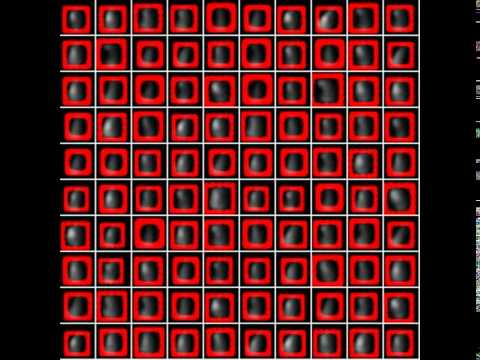

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo("Zt-7MI9eKEo")

## Ok, But how does it really work?

In a recurrent VAE model, the encoder takes in the entire input image at every single timestep. In DRAW we need to focus in the attention gate between the two of them, so the encoder only receives the portion of our image that the network deems is important at that timestep. That first attention gate is called the <strong>"read"</strong> attention.

The "read" attention consists in two parts:
1. Choosing the important portion
2. Cropping the image and forget about other parts


### Choosing the important portion of an image

In order to determine which part of the image to focus on, we need some sort of observation to make a decision based on. In DRAW, we use the previous timestep's decoder hidden state. Using a simple fully-connected layer, we can map the hidden state to three parameters that represent our square crop: center x, center y, and the scale.

<div align="center">
    <img src="images/04.png">
</div>

### Cropping the image

Now, instead of encoding the entire image, we crop it so only a small part of the image is encoded. This code is then passed through the system, and decoded back into a small patch.

We now arrive to the second part of our attention gate, the <strong>"write"</strong> attention, which have the same setup as the "read" section, except that the "write" attention gate uses the current decoder instead of the previous timestep's decoder.

<div align="center">
    <img src="images/05.png">
</div>

### Wait...is that really done in practice?

While describing the attention mechanism as a crop makes sense intuitively, in practice, a different method is used. The model structure described above is still accurate, but a matrix of <a href="https://en.wikipedia.org/wiki/Gaussian_filter">gaussian filters</a> instead of a crop is used.

In DRAW, we take an array of gaussian filters, each with their centers spaced apart evenly. 

## Show me the money...or the code instead.
#### We will use Eric Jang's code as a base but we will clean it up a bit and comment it in order to make it more easy to understand.

In [2]:
# first we import our libraries
import tensorflow as tf
from tensorflow.examples.tutorials import mnist
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import scipy.misc
import os

Eric provide us with some great functions that will help us build our "read" and "write" attention gates as well as a function to filter the initial state that we will use below, but first, we will need add new functions that will allow us to create a dense layer as well as merge the images and save them into our local machine for our updated code.

In [3]:
# fully-conected layer
def dense(x, inputFeatures, outputFeatures, scope=None, with_w=False):
    with tf.variable_scope(scope or "Linear"):
        matrix = tf.get_variable("Matrix", [inputFeatures, outputFeatures], tf.float32, tf.random_normal_initializer(stddev=0.02))
        bias = tf.get_variable("bias", [outputFeatures], initializer=tf.constant_initializer(0.0))
        if with_w:
            return tf.matmul(x, matrix) + bias, matrix, bias
        else:
            return tf.matmul(x, matrix) + bias

# merge images
def merge(images, size):
    h, w = images.shape[1], images.shape[2]
    img = np.zeros((h * size[0], w * size[1]))
    for idx, image in enumerate(images):
        i = idx % size[1]
        j = idx / size[1]
        img[j*h:j*h+h, i*w:i*w+w] = image
    return img

# save image on local machine        
def ims(name, img):
    # print img[:10][:10]
    scipy.misc.toimage(img, cmin=0, cmax=1).save(name)

Let's now put the code all togheter for the sake of completition.

In [4]:
# DRAW implementation
class draw_model():
    def __init__(self):
        
        # First we download the MNIST dataset into our local machine.
        self.mnist = input_data.read_data_sets("data/", one_hot=True)
        print "------------------------------------"
        print "MNIST Dataset Succesufully Imported"
        print "------------------------------------"
        self.n_samples = self.mnist.train.num_examples

        # We set up the model parameters 
        # ------------------------------
        # image width,height
        self.img_size = 28 
        # read glimpse grid width/height
        self.attention_n = 5 
        # number of hidden units / output size in LSTM
        self.n_hidden = 256  
        # QSampler output size
        self.n_z = 10
        # MNIST generation sequence length
        self.sequence_length = 10
        # training minibatch size
        self.batch_size = 64
        # workaround for variable_scope(reuse=True)
        self.share_parameters = False
        
        # Build our model 
        self.images = tf.placeholder(tf.float32, [None, 784]) # input (batch_size * img_size)
        self.e = tf.random_normal((self.batch_size, self.n_z), mean=0, stddev=1) # Qsampler noise
        self.lstm_enc = tf.nn.rnn_cell.LSTMCell(self.n_hidden, state_is_tuple=True) # encoder Op
        self.lstm_dec = tf.nn.rnn_cell.LSTMCell(self.n_hidden, state_is_tuple=True) # decoder Op

        # Define our state variables
        self.cs = [0] * self.sequence_length # sequence of canvases
        self.mu, self.logsigma, self.sigma = [0] * self.sequence_length, [0] * self.sequence_length, [0] * self.sequence_length

        # Initial states
        h_dec_prev = tf.zeros((self.batch_size, self.n_hidden))
        enc_state = self.lstm_enc.zero_state(self.batch_size, tf.float32)
        dec_state = self.lstm_dec.zero_state(self.batch_size, tf.float32)

        # Construct the unrolled computational graph
        x = self.images
        for t in range(self.sequence_length):
            # error image + original image
            c_prev = tf.zeros((self.batch_size, self.img_size**2)) if t == 0 else self.cs[t-1]
            x_hat = x - tf.sigmoid(c_prev)
            # read the image
            r = self.read_basic(x,x_hat,h_dec_prev)
            #sanity check
            print r.get_shape()
            # encode to guass distribution
            self.mu[t], self.logsigma[t], self.sigma[t], enc_state = self.encode(enc_state, tf.concat(1, [r, h_dec_prev]))
            # sample from the distribution to get z
            z = self.sampleQ(self.mu[t],self.sigma[t])
            #sanity check
            print z.get_shape()
            # retrieve the hidden layer of RNN
            h_dec, dec_state = self.decode_layer(dec_state, z)
            #sanity check
            print h_dec.get_shape()
            # map from hidden layer 
            self.cs[t] = c_prev + self.write_basic(h_dec)
            h_dec_prev = h_dec
            self.share_parameters = True # from now on, share variables

        # Loss function
        self.generated_images = tf.nn.sigmoid(self.cs[-1])
        self.generation_loss = tf.reduce_mean(-tf.reduce_sum(self.images * tf.log(1e-10 + self.generated_images) + (1-self.images) * tf.log(1e-10 + 1 - self.generated_images),1))

        kl_terms = [0]*self.sequence_length
        for t in xrange(self.sequence_length):
            mu2 = tf.square(self.mu[t])
            sigma2 = tf.square(self.sigma[t])
            logsigma = self.logsigma[t]
            kl_terms[t] = 0.5 * tf.reduce_sum(mu2 + sigma2 - 2*logsigma, 1) - self.sequence_length*0.5 # each kl term is (1xminibatch)
        self.latent_loss = tf.reduce_mean(tf.add_n(kl_terms))
        self.cost = self.generation_loss + self.latent_loss
        
        # Optimization
        optimizer = tf.train.AdamOptimizer(1e-3, beta1=0.5)
        grads = optimizer.compute_gradients(self.cost)
        for i,(g,v) in enumerate(grads):
            if g is not None:
                grads[i] = (tf.clip_by_norm(g,5),v)
        self.train_op = optimizer.apply_gradients(grads)

        self.sess = tf.Session()
        self.sess.run(tf.initialize_all_variables())
        
    # Our training function
    def train(self):
        for i in xrange(20000):
            xtrain, _ = self.mnist.train.next_batch(self.batch_size)
            cs, gen_loss, lat_loss, _ = self.sess.run([self.cs, self.generation_loss, self.latent_loss, self.train_op], feed_dict={self.images: xtrain})
            print "iter %d genloss %f latloss %f" % (i, gen_loss, lat_loss)
            if i % 500 == 0:

                cs = 1.0/(1.0+np.exp(-np.array(cs))) # x_recons=sigmoid(canvas)

                for cs_iter in xrange(10):
                    results = cs[cs_iter]
                    results_square = np.reshape(results, [-1, 28, 28])
                    print results_square.shape
                    ims("results/"+str(i)+"-step-"+str(cs_iter)+".jpg",merge(results_square,[8,8]))
            
    # Eric Jang's main functions
    # --------------------------
    # locate where to put attention filters on hidden layers
    def attn_window(self, scope, h_dec):
        with tf.variable_scope(scope, reuse=self.share_parameters):
            parameters = dense(h_dec, self.n_hidden, 5)
        # center of 2d gaussian on a scale of -1 to 1
        gx_, gy_, log_sigma2, log_delta, log_gamma = tf.split(1,5,parameters)

        # move gx/gy to be a scale of -imgsize to +imgsize
        gx = (self.img_size+1)/2 * (gx_ + 1)
        gy = (self.img_size+1)/2 * (gy_ + 1)

        sigma2 = tf.exp(log_sigma2)
        # distance between patches
        delta = (self.img_size - 1) / ((self.attention_n-1) * tf.exp(log_delta))
        # returns [Fx, Fy, gamma]
        return self.filterbank(gx,gy,sigma2,delta) + (tf.exp(log_gamma),)
    
    # Construct patches of gaussian filters
    def filterbank(self, gx, gy, sigma2, delta):
        # 1 x N, look like [[0,1,2,3,4]]
        grid_i = tf.reshape(tf.cast(tf.range(self.attention_n), tf.float32),[1, -1])
        # individual patches centers
        mu_x = gx + (grid_i - self.attention_n/2 - 0.5) * delta
        mu_y = gy + (grid_i - self.attention_n/2 - 0.5) * delta
        mu_x = tf.reshape(mu_x, [-1, self.attention_n, 1])
        mu_y = tf.reshape(mu_y, [-1, self.attention_n, 1])
        # 1 x 1 x imgsize, looks like [[[0,1,2,3,4,...,27]]]
        im = tf.reshape(tf.cast(tf.range(self.img_size), tf.float32), [1, 1, -1])
        # list of gaussian curves for x and y
        sigma2 = tf.reshape(sigma2, [-1, 1, 1])
        Fx = tf.exp(-tf.square((im - mu_x) / (2*sigma2)))
        Fy = tf.exp(-tf.square((im - mu_x) / (2*sigma2)))
        # normalize area-under-curve 
        Fx = Fx / tf.maximum(tf.reduce_sum(Fx,2,keep_dims=True),1e-8)
        Fy = Fy / tf.maximum(tf.reduce_sum(Fy,2,keep_dims=True),1e-8)
        return Fx, Fy


    # read operation without attention
    def read_basic(self, x, x_hat, h_dec_prev):
        return tf.concat(1,[x,x_hat])

    # read operation with attention
    def read_attention(self, x, x_hat, h_dec_prev):
        Fx, Fy, gamma = self.attn_window("read", h_dec_prev)
        # apply parameters for patch of gaussian filters
        def filter_img(img, Fx, Fy, gamma):
            Fxt = tf.transpose(Fx, perm=[0,2,1])
            img = tf.reshape(img, [-1, self.img_size, self.img_size])
            # apply the gaussian patches
            glimpse = tf.batch_matmul(Fy, tf.batch_matmul(img, Fxt))
            glimpse = tf.reshape(glimpse, [-1, self.attention_n**2])
            # scale using the gamma parameter
            return glimpse * tf.reshape(gamma, [-1, 1])
        x = filter_img(x, Fx, Fy, gamma)
        x_hat = filter_img(x_hat, Fx, Fy, gamma)
        return tf.concat(1, [x, x_hat])

    # encoder function for attention patch
    def encode(self, prev_state, image):
        # update the RNN with our image
        with tf.variable_scope("encoder",reuse=self.share_parameters):
            hidden_layer, next_state = self.lstm_enc(image, prev_state)

        # map the RNN hidden state to latent variables
        with tf.variable_scope("mu", reuse=self.share_parameters):
            mu = dense(hidden_layer, self.n_hidden, self.n_z)
        with tf.variable_scope("sigma", reuse=self.share_parameters):
            logsigma = dense(hidden_layer, self.n_hidden, self.n_z)
            sigma = tf.exp(logsigma)
        return mu, logsigma, sigma, next_state
    
    def sampleQ(self, mu, sigma):
        return mu + sigma*self.e
    
    # decoder function
    def decode_layer(self, prev_state, latent):
        # update decoder RNN using our latent variable
        with tf.variable_scope("decoder", reuse=self.share_parameters):
            hidden_layer, next_state = self.lstm_dec(latent, prev_state)

        return hidden_layer, next_state

    # write operation without attention
    def write_basic(self, hidden_layer):
        # map RNN hidden state to image
        with tf.variable_scope("write", reuse=self.share_parameters):
            decoded_image_portion = dense(hidden_layer, self.n_hidden, self.img_size**2)
        return decoded_image_portion
    
    # write operation with attention
    def write_attention(self, hidden_layer):
        with tf.variable_scope("writeW", reuse=self.share_parameters):
            w = dense(hidden_layer, self.n_hidden, self.attention_n**2)
        w = tf.reshape(w, [self.batch_size, self.attention_n, self.attention_n])
        Fx, Fy, gamma = self.attn_window("write", hidden_layer)
        Fyt = tf.transpose(Fy, perm=[0,2,1])
        wr = tf.batch_matmul(Fyt, tf.batch_matmul(w, Fx))
        wr = tf.reshape(wr, [self.batch_size, self.img_size**2])
        return wr * tf.reshape(1.0/gamma, [-1, 1])

model = draw_model()
model.train()

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting data/t10k-labels-idx1-ubyte.gz
------------------------------------
MNIST Dataset Succesufully Imported
------------------------------------
(64, 1568)
(64, 10)
(64, 256)
(64, 1568)
(64, 10)
(64, 256)
(64, 1568)
(64, 10)
(64, 256)
(64, 1568)
(64, 10)
(64, 256)
(64, 1568)
(64, 10)
(64, 256)
(64, 1568)
(64, 10)
(64, 256)
(64, 1568)
(64, 10)
(64, 256)
(64, 1568)
(64, 10)
(64, 256)
(64, 1568)
(64, 10)
(64, 256)
(64, 1568)
(64, 10)
(64, 256)
iter 0 genloss 561.023254 latloss 0.426661
(64, 28, 28)
(64, 28, 28)
(64, 28, 28)
(64, 28, 28)
(64, 28, 28)
(64, 28, 28)
(64, 28, 28)
(64, 28, 28)
(64, 28, 28)
(64